# Contour length index (CLI)

In [1]:
from IPython.display import HTML
%run ../../_setup.py

import numpy as np
from xarray import open_dataset, open_mfdataset
import pyproj
import datetime

import matplotlib.pyplot as plt
%matplotlib notebook

### Function to calculate contour length for a particular contour.

In [2]:
from skimage import measure

def contour_length(xr_ds, var, contour, timemean=True, time_sel=slice(None, None), lon_sel=slice(None, None), lat_sel=slice(None, None), transform=None):
    
    # take the time mean field
    if time_sel != slice(None, None) and timemean:
        timemean = xr_ds[var].sel(time=time_sel).mean('time')
    elif timemean:
        timemean = xr_ds[var].mean('time')
    else:
        raise ValueError('Field can have a maximum number of 2 dimension but got %s', xr_ds[var].ndim)
    
    # select spatial area
    if lon_sel != slice(None, None):
        ctfield = timemean.sel(longitude=lon_sel)
    if lat_sel != slice(None, None):
        ctfield = timemean.sel(latitude=lat_sel)
    
    # find longest contour
    contours = measure.find_contours(ctfield, contour)
    contour = max(contours, key=lambda x: len(x))

    lon_ct, lat_ct = contour[:, 1], contour[:, 0]
    lon_ct = np.nanmin(ctfield.longitude) + np.unique(np.diff(ctfield.longitude)) * lon_ct
    lat_ct = np.nanmin(ctfield.latitude) + np.unique(np.diff(ctfield.latitude)) * lat_ct

    # transform polar coordinates to cartesian coordinates
    if transform is not None:
        WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
        x_ct, y_ct = pyproj.transform(WGS84, transform, lon_ct, lat_ct)
    else:
        x_ct, y_ct = lon_ct, lat_ct

    #  calculate contour length in meters
    dx, dy = np.diff(x_ct), np.diff(y_ct)
    cl = np.sum(np.sqrt(dx**2 + dy**2))
    
    return cl, lon_ct, lat_ct, timemean

### Annual mean contours and contour length

In [3]:
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'SEALEVEL_GLO_PHY_L4_REP_OBS_137_-52.4_147_-48_199801-199812.nc')
ssh = open_dataset(input_file)


In [4]:
# var = 'adt'
# contour = 0.3
# time_sel = '1998-10'
# lon_sel = slice(138, 145)
# lat_sel = slice(None, None)
# timemean = True
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

annualmeancl, lon_ct, lat_ct, timemean = contour_length(ssh, 'adt', 0.15, lon_sel=slice(138, 145), transform=UTM54)

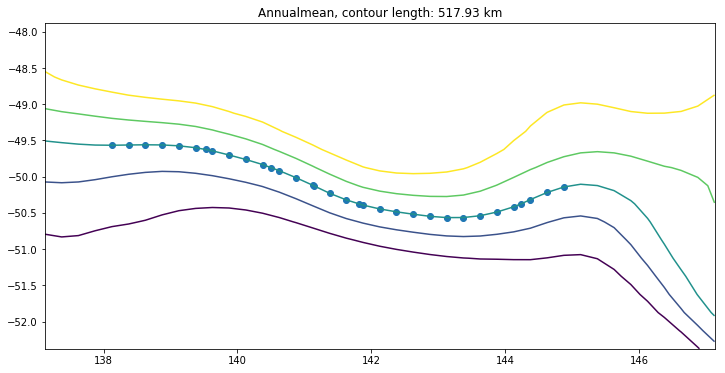

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.contour(ssh.longitude, ssh.latitude, timemean, np.linspace(-0.1, 0.4, 5))
plt.title('Annualmean, contour length: %s km' %round(annualmeancl/1000, 2))
plt.scatter(lon_ct, lat_ct)


In [27]:
annualmeancl

517926.8729244702

### Monthly mean contours and contour length for year 1998

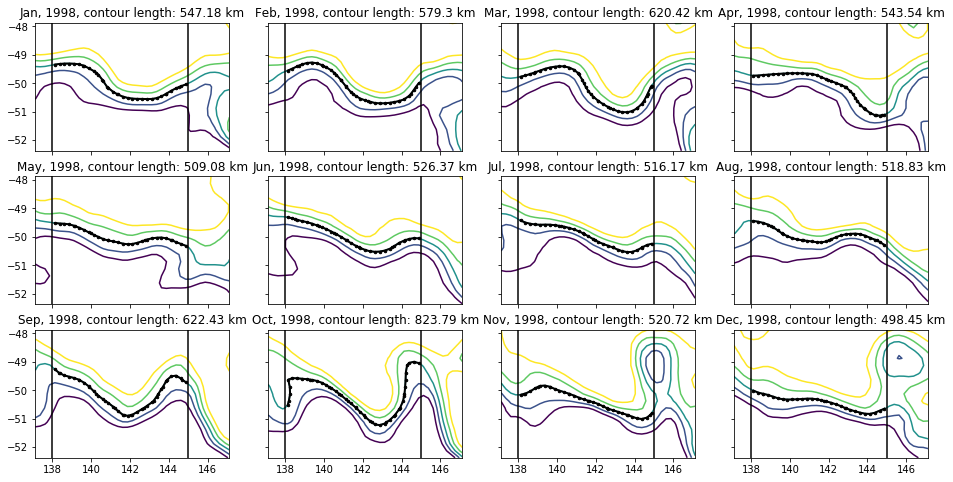

In [6]:
var = 'adt'
contour = 0.15
lon_sel = slice(138, 145)
year = 1998
month = 1

fig, ax = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True)
rows, cols = ax.shape

cli = []
for row in range(rows):
    for col in range(cols):
        time_sel = '%s-%02d' % (year, month)

        cl, lon_ct, lat_ct, timemean = contour_length(ssh, var, contour, time_sel=time_sel, lon_sel=lon_sel, transform=UTM54)
        cli.append((cl - annualmeancl)/1000)
        ct = ax[row, col].contour(ssh.longitude, ssh.latitude, timemean, np.linspace(-0.1, 0.4, 5))
#         ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, [0.15], colors='r', linewidths=2)
        ax[row, col].plot(lon_ct, lat_ct, 'k.-', linewidth=2, markersize=5)
        ax[row, col].set_title(datetime.date(year, month, 1).strftime('%b, %Y') + ', contour length: %s km' %round(cl/1000, 2))
        ax[row, col].axvline(138, color='k')
        ax[row, col].axvline(145, color='k')

        month += 1

### Determine propagation of meander by hovmoller diagram from the sea level anomaly

In [7]:
# for each timestep average latitudinal values from -48.6 - -51.8
sla = ssh['sla'].sel(longitude=slice(138, 145), latitude=slice(-51.8, -48.6))
hm = np.ma.masked_all(sla.shape[0::2])
for it in range(len(sla.time)):
    hm[it, :] = np.average(sla[it,], axis=0)

In [8]:
import pandas as pd
pd.date_range(start='1/1/1998', periods=12, freq='M')

df = pd.read_csv(os.path.join(datadir, 'external', 'sam', 'monthly_sam_1957-2007.txt'), sep='\s+')
df.columns = range(1, 13)
df = df.stack()
year = df.index.get_level_values(0).values
month = df.index.get_level_values(1).values

df.index = pd.PeriodIndex(year=year, month=month, freq='M')

df98 = pd.DataFrame(df.loc[df.index.year == 1998], columns=['SAM'])
df98['SAMpos'] = df98['SAM'] > 0
df98['CLI'] = cli
df98['CLIpos'] = df98['CLI'] > 0


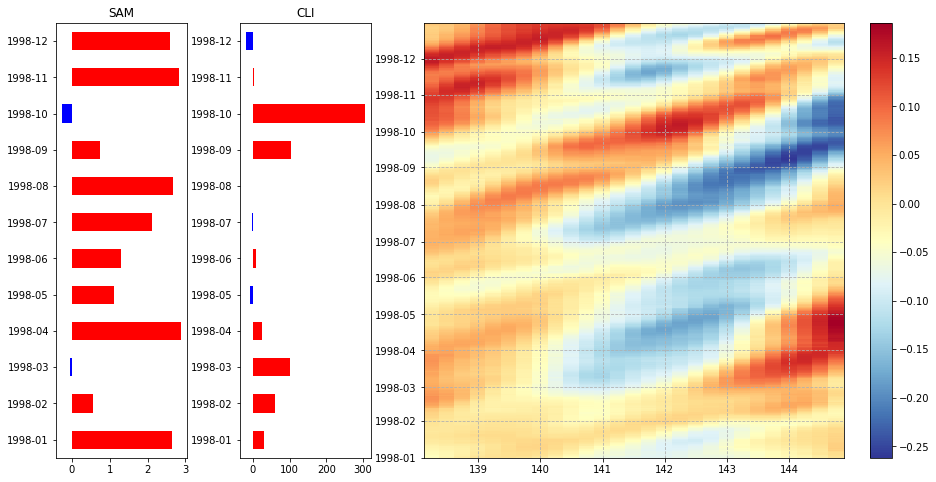

In [9]:
fig, ax = plt.subplots(1,3, gridspec_kw = {'width_ratios':[1, 1, 4]}, figsize = (16,8))
df98['SAM'].plot(kind='barh', ax=ax[0], color=df98.SAMpos.map({True: 'r', False: 'b'}))
df98['CLI'].plot(kind='barh', ax=ax[1], color=df98.CLIpos.map({True: 'r', False: 'b'}))
pcol = ax[2].pcolormesh(sla.longitude, sla.time, hm, cmap=plt.cm.RdYlBu_r)
ax[0].set_title('SAM')
ax[1].set_title('CLI')
plt.colorbar(pcol, ax=ax[2])
ax[2].grid(linestyle='--')

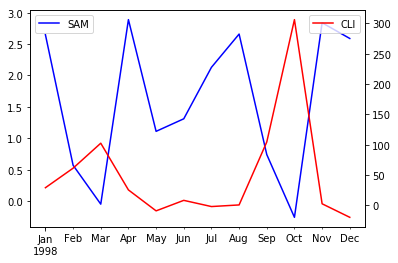

In [10]:
fig, ax = plt.subplots()
ax1 = df98['SAM'].plot(color='b')
plt.legend()
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df98['CLI'].plot(color='r', ax=ax2)
plt.legend()

### Monthly mean contours and contour length from 1998-2016

In [32]:
input_folder = os.path.join(datadir, 'external', 'ssh', 'rep')
files = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if int(file[-7:-3]) in np.arange(1993, 2017)]

ssh = open_mfdataset(files).sel(longitude=slice(137, 147), latitude=slice(-52.4, -48))

var = 'adt'
contour = 0.15
lon_sel = slice(138, 145)

climatology = ssh.adt.mean('time')
climatologycl, lon_ct, lat_ct, timemean = contour_length(ssh, var, contour, lon_sel=slice(138, 145), transform=UTM54)
climatologycl

535887.4900782041

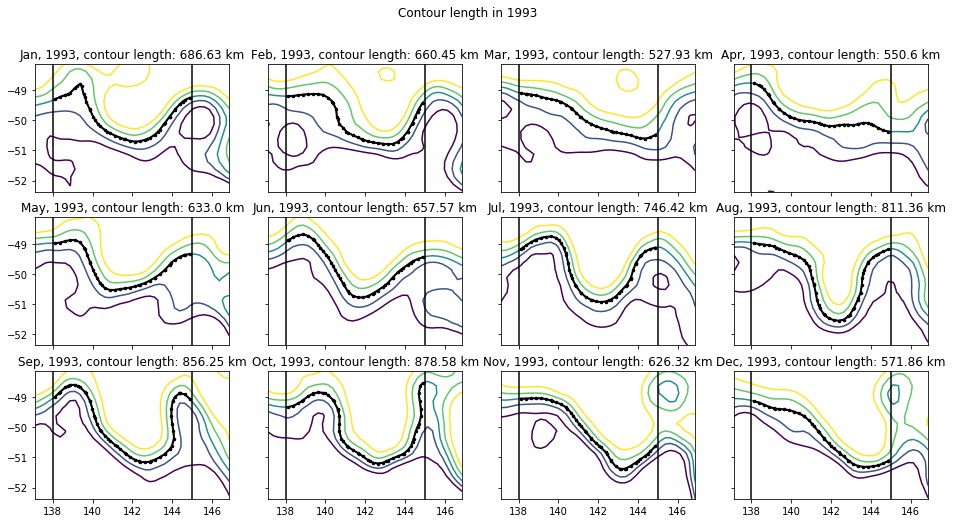

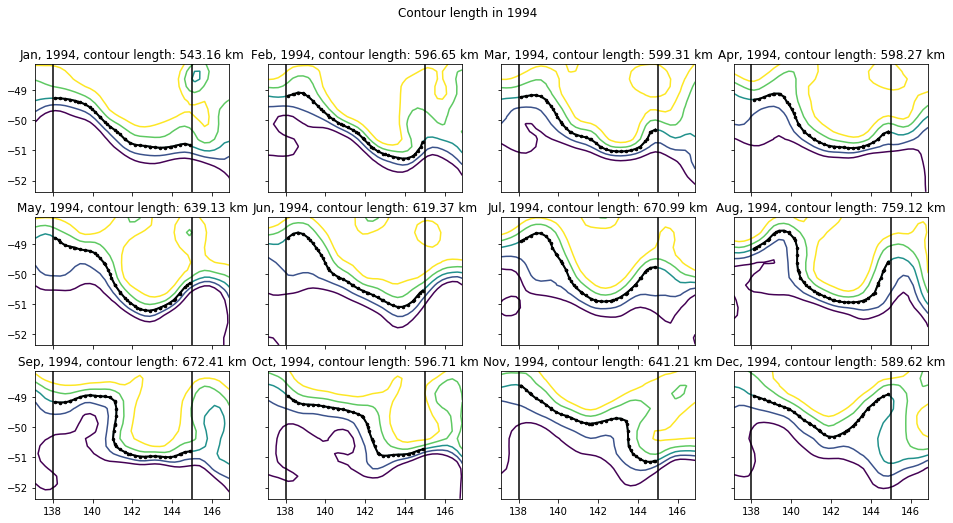

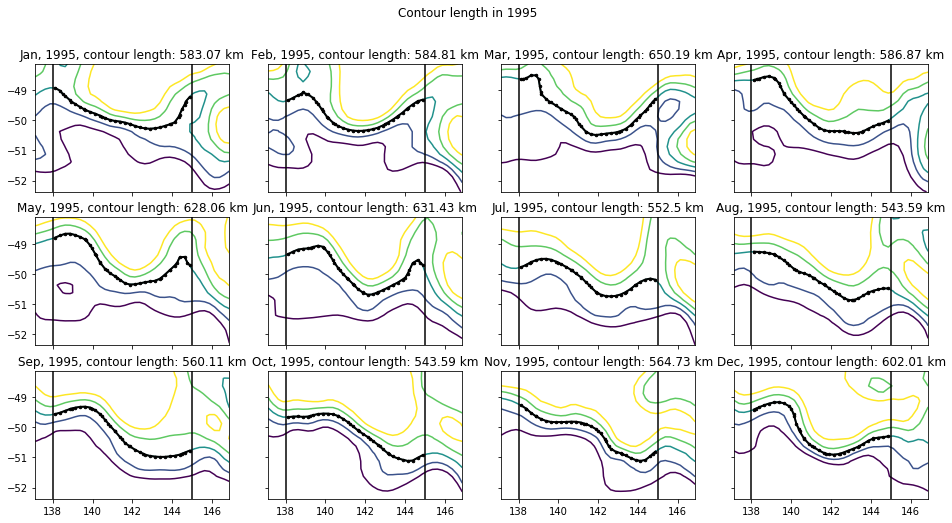

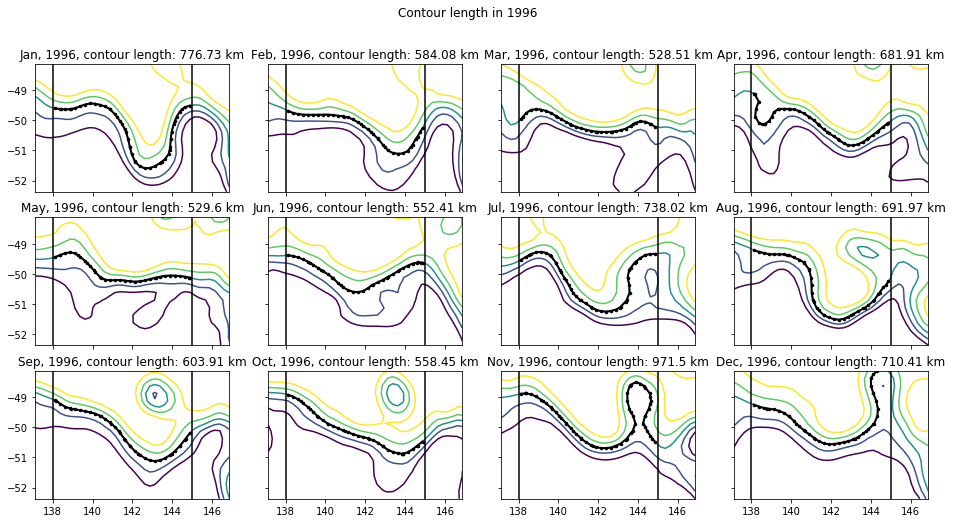

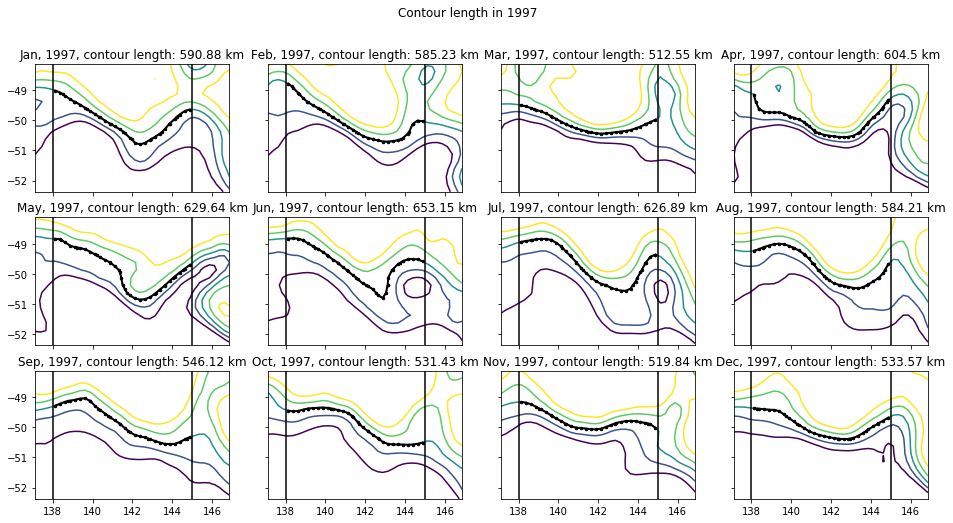

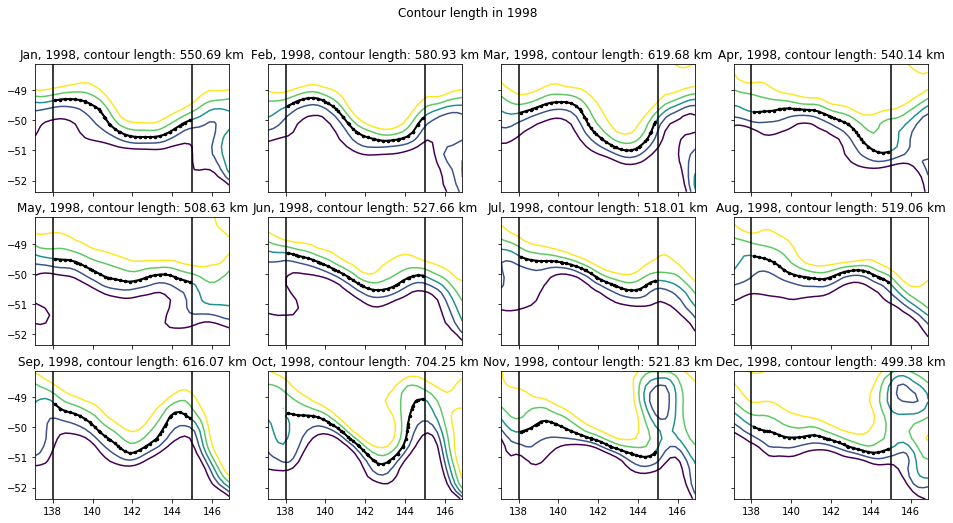

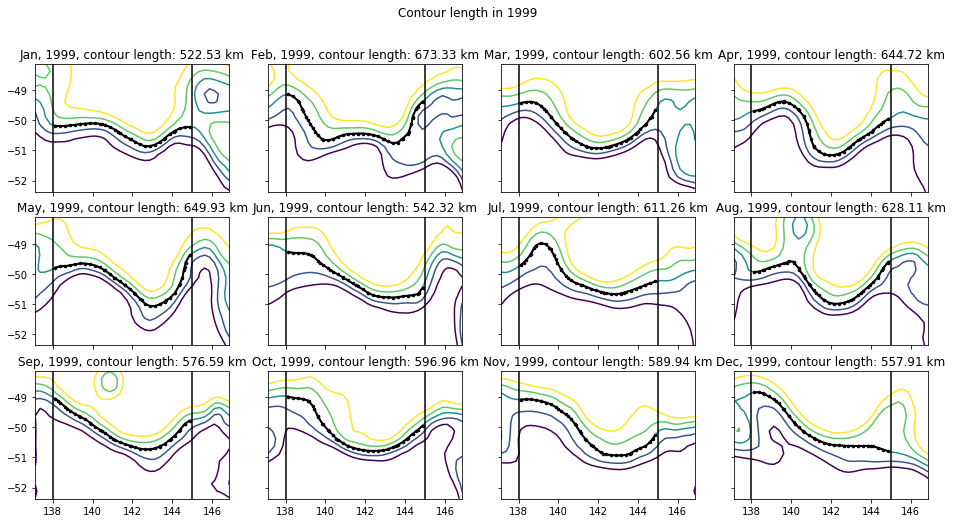

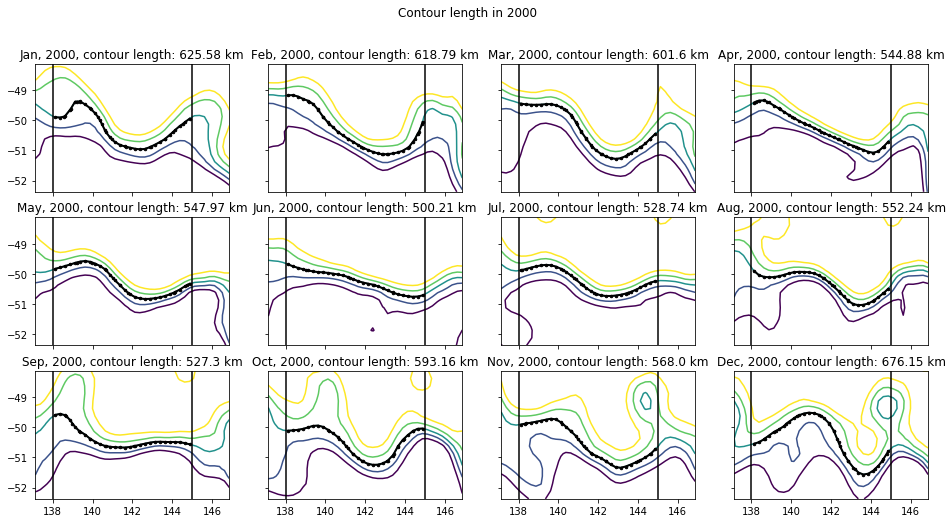

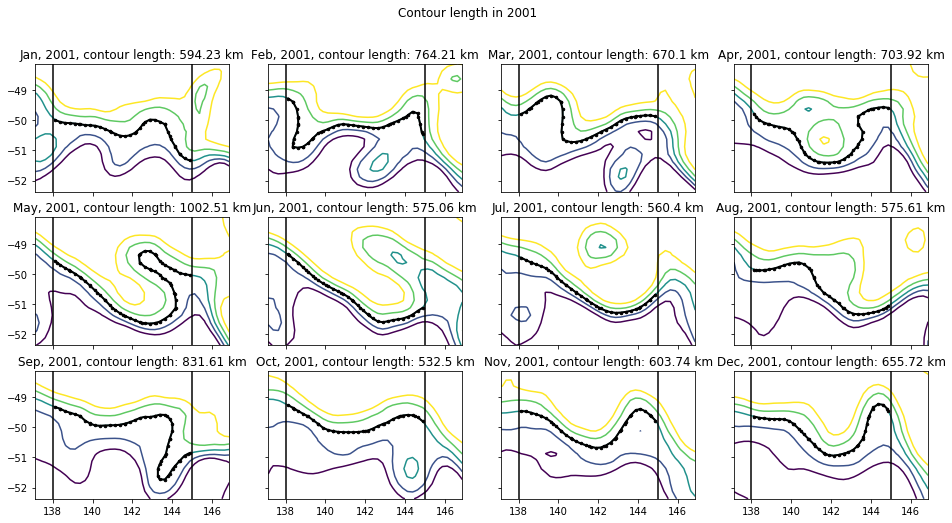

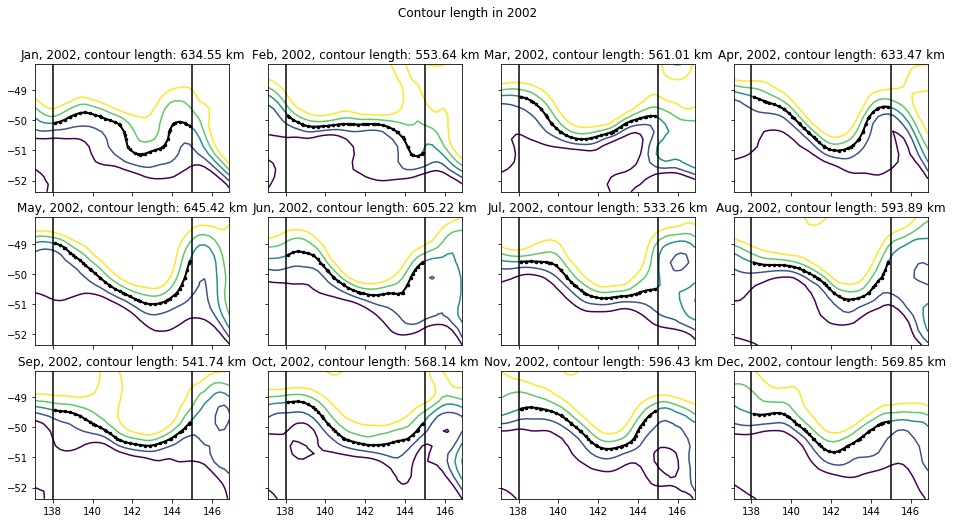

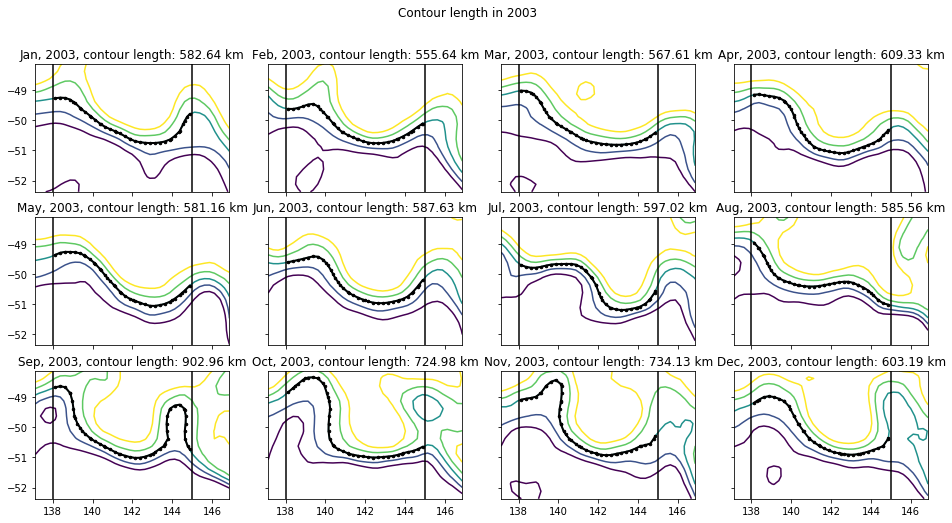

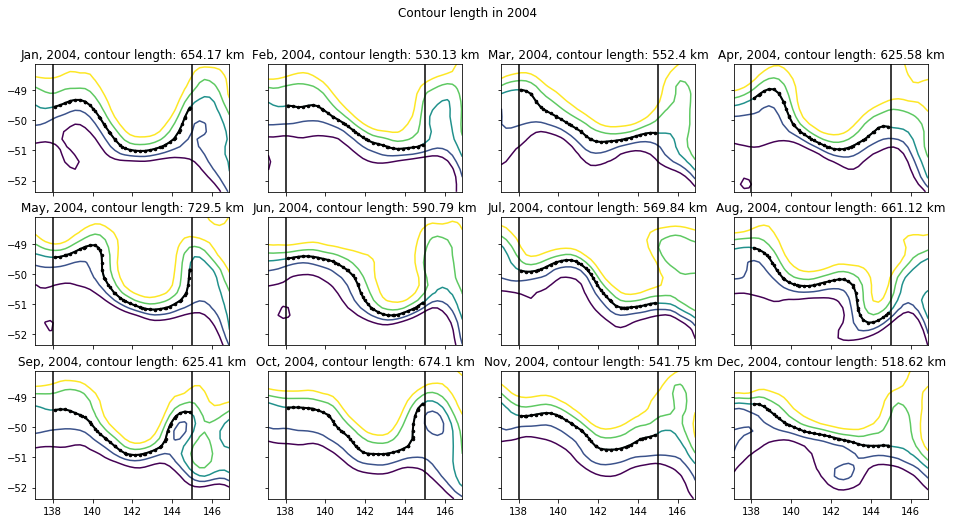

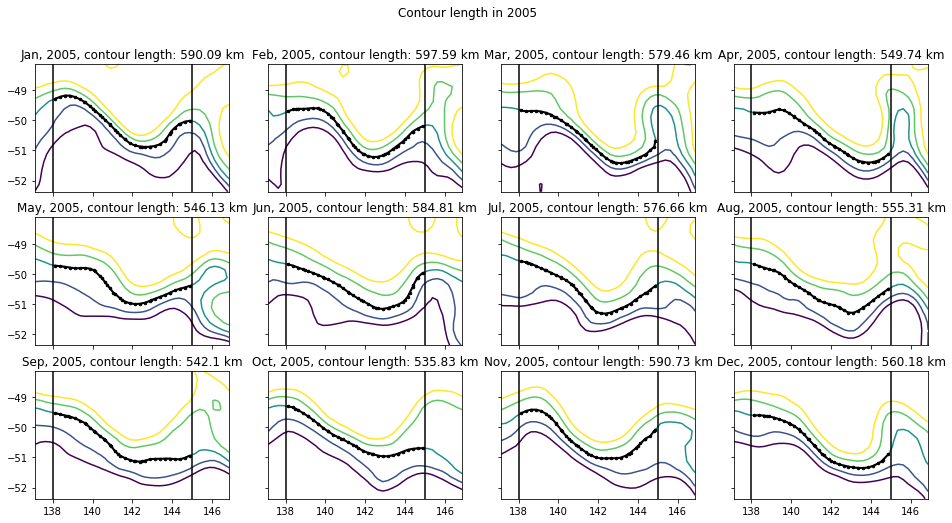

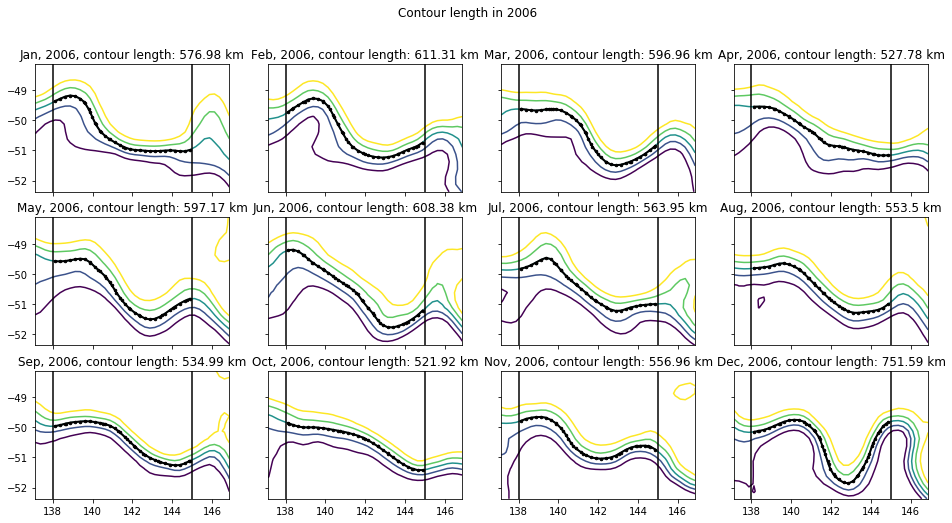

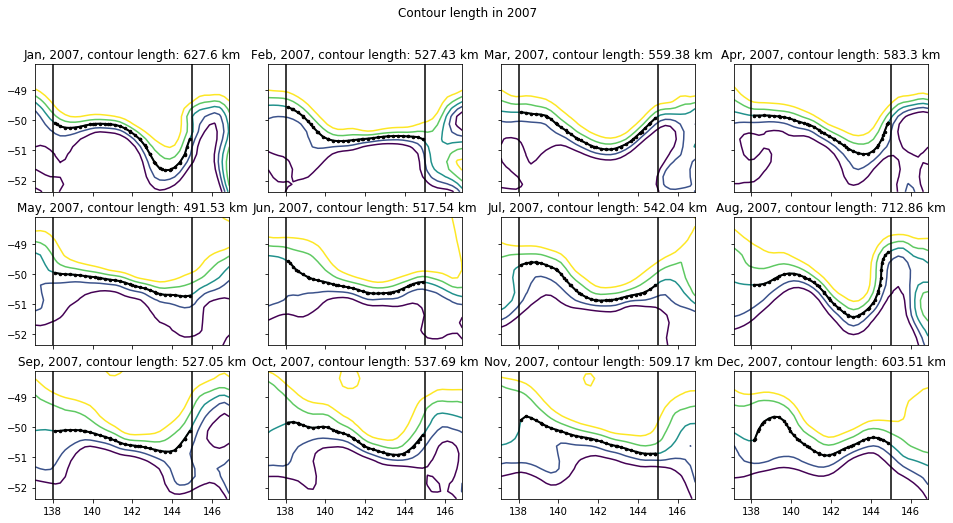

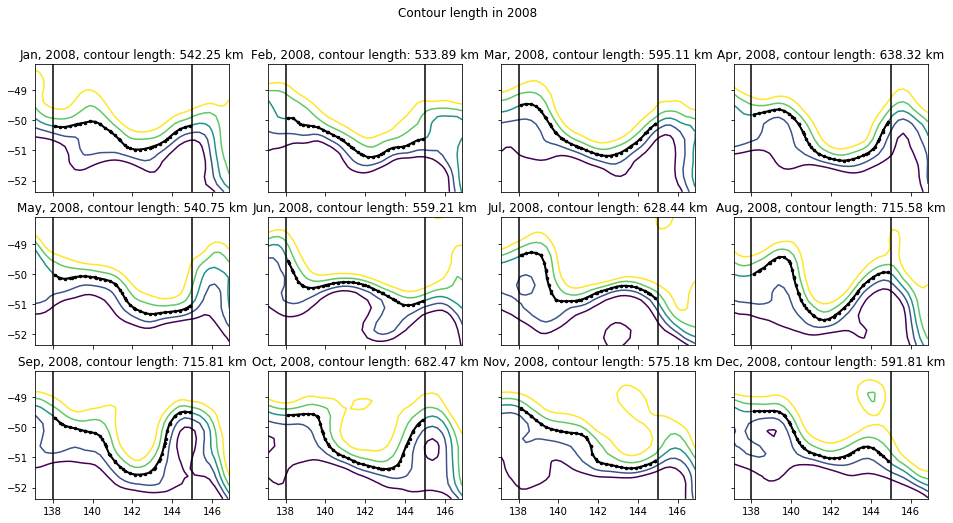

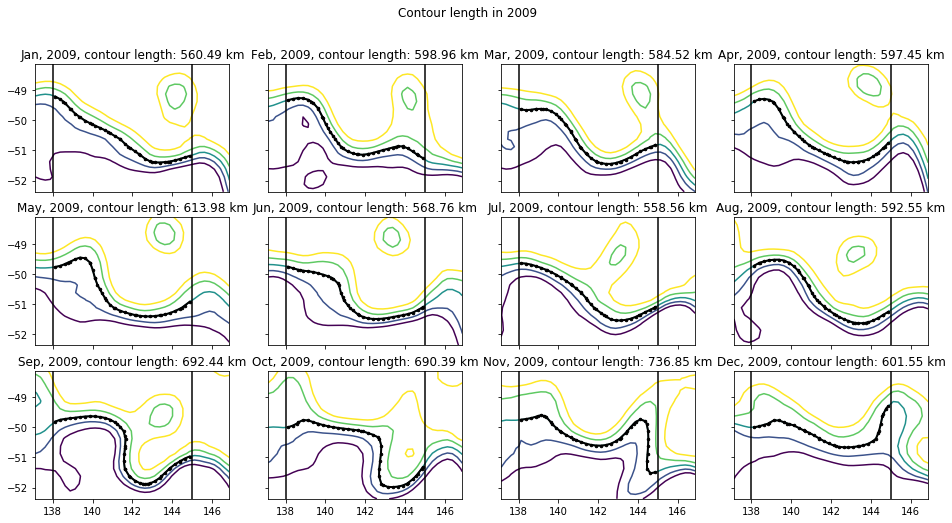

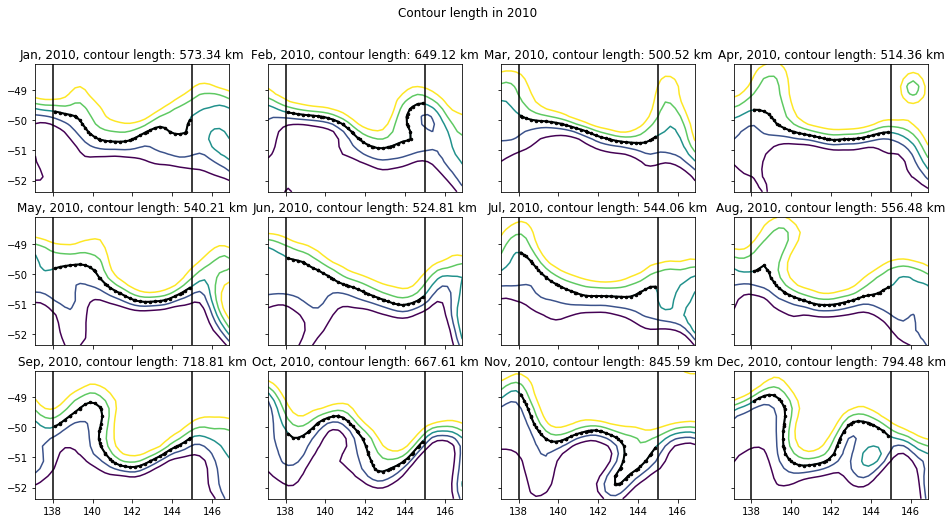

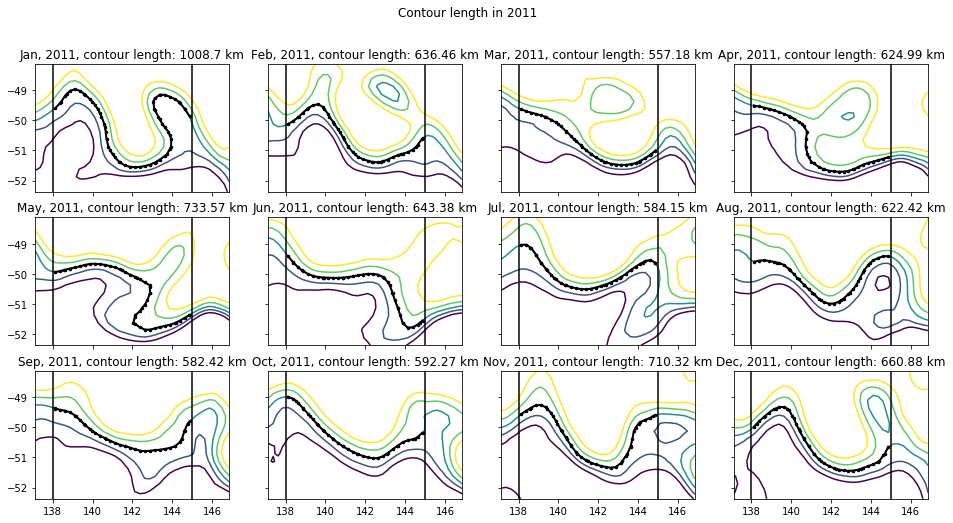

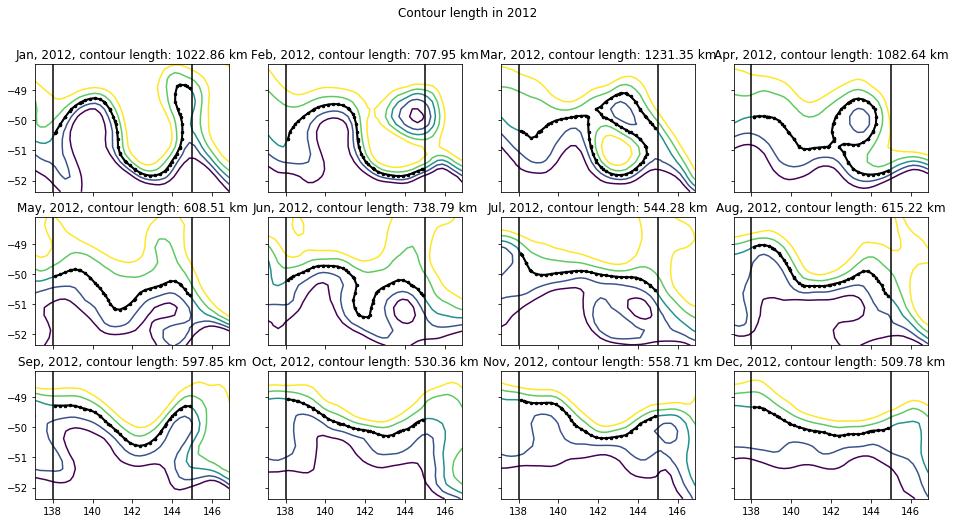

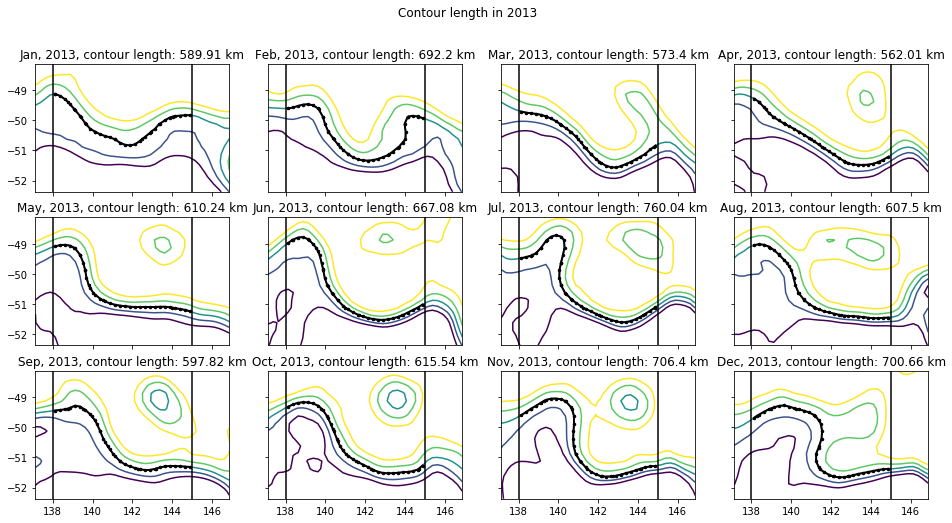

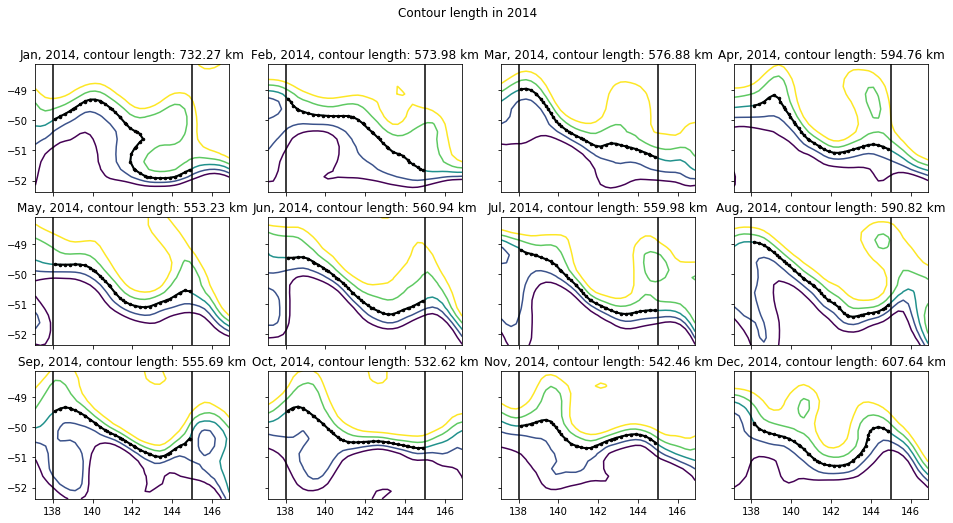

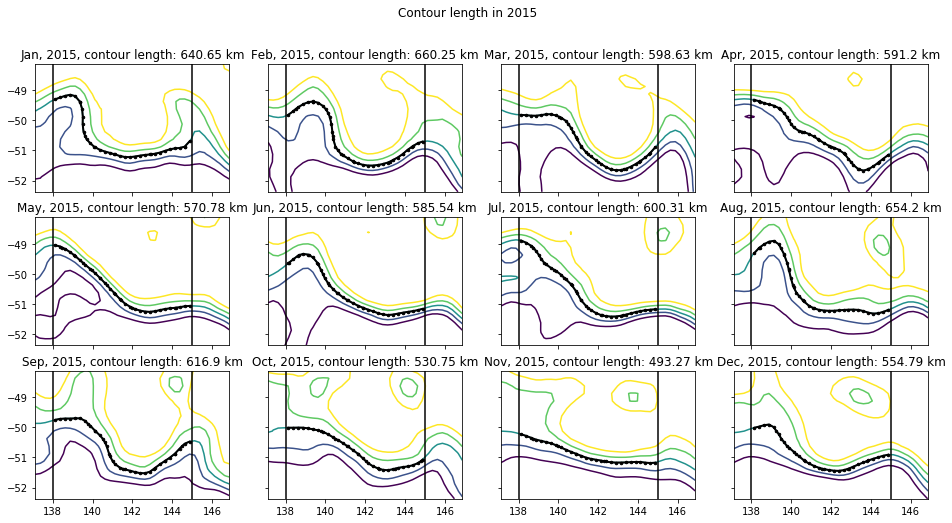

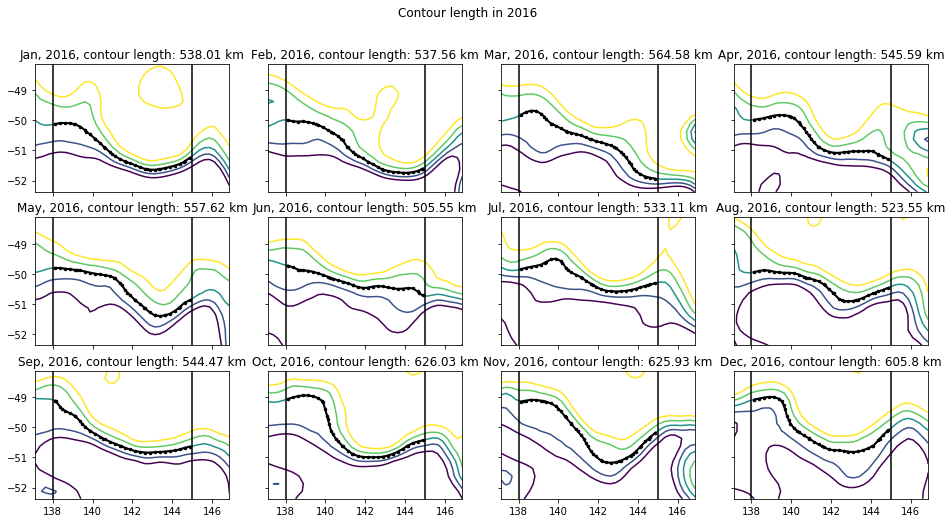

In [31]:



cli = []
for year in range(1993, 2017):
    
    fig, ax = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True)
    rows, cols = ax.shape
    row, col = 0, 0

    for month in range(1, 13):
#         month = [(t.year == nyr) & (t.month == nmth) for t in time]
        time_sel = '%s-%02d' % (year, month)
#         print(time_sel)
        cl, lon_ct, lat_ct, timemean = contour_length(ssh, var, contour, 
                                                      time_sel=time_sel, lon_sel=lon_sel, transform=UTM54)
        cli.append((cl - climatologycl)/1000) # in km
        
        ct = ax[row, col].contour(ssh.longitude, ssh.latitude, timemean, np.linspace(-0.1, 0.4, 5))
        ax[row, col].plot(lon_ct, lat_ct, 'k.-', linewidth=2, markersize=5)
        ax[row, col].set_title(datetime.date(year, month, 1).strftime('%b, %Y') + ', contour length: %s km' %round(cl/1000, 2))
        ax[row, col].axvline(138, color='k')
        ax[row, col].axvline(145, color='k')
        
        col += 1
        if col % cols == 0:
            col = 0
            row += 1
    fig.suptitle('Contour length in %s' %year)  
    plt.show()

Text(0.5,1,'CLI')

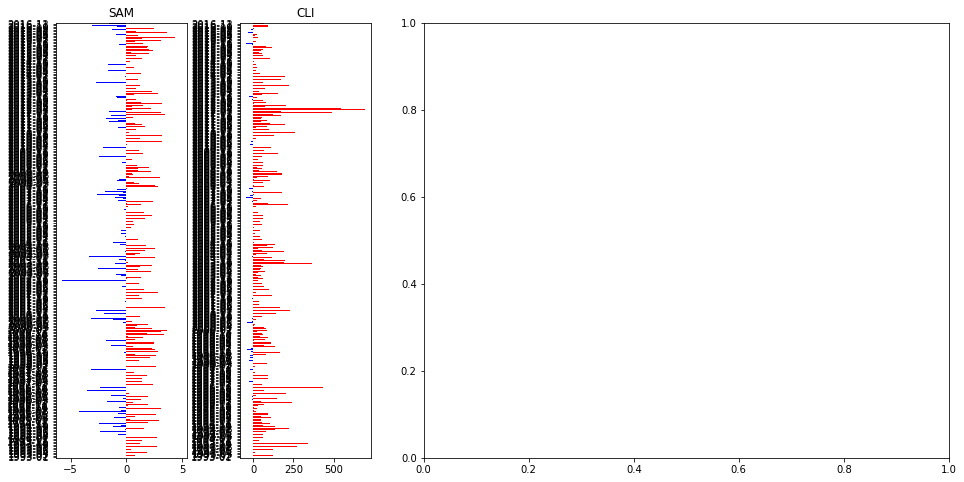

In [34]:
df_new = pd.DataFrame(df.loc[(df.index.year >= 1993) & (df.index.year < 2017) ], columns=['SAM'])
df_new['SAMpos'] = df_new['SAM'] > 0
df_new['CLI'] = cli
df_new['CLIpos'] = df_new['CLI'] > 0

fig, ax = plt.subplots(1,3, gridspec_kw = {'width_ratios':[1, 1, 4]}, figsize = (16,8))
df_new['SAM'].plot(kind='barh', ax=ax[0], color=df_new.SAMpos.map({True: 'r', False: 'b'}))
df_new['CLI'].plot(kind='barh', ax=ax[1], color=df_new.CLIpos.map({True: 'r', False: 'b'}))
# pcol = ax[2].pcolormesh(sl['longitude'][4:-9], time, hm, cmap=plt.cm.RdYlBu_r)
ax[0].set_title('SAM')
ax[1].set_title('CLI')
# plt.colorbar(pcol, ax=ax[2])

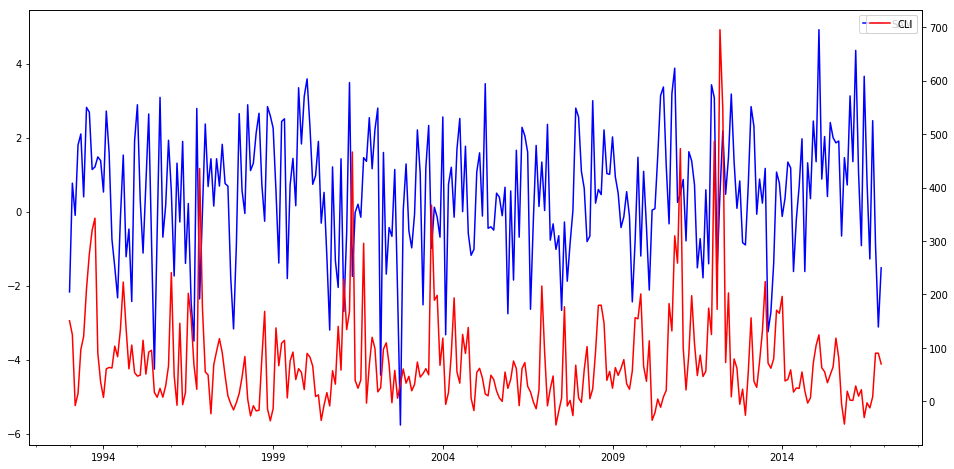

In [38]:
fig, ax = plt.subplots(figsize=(16, 8))
ax1 = df_new['SAM'].plot(color='b')
plt.legend()
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df_new['CLI'].plot(color='r', ax=ax2)
plt.legend()
